In [1]:
from pyspark.sql import SparkSession, functions as F
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("TrainingMLP")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config('spark.driver.memory', '8g')  
    .config('spark.executor.memory', '8g') 
    .getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/08/24 15:39:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
file_path = '../data/curated/*'
df = spark.read.parquet(file_path)
df = df.sample(withReplacement=False, fraction=0.7, seed=42)
df.show(10)

+------------+-----------+--------+------+-------+----------+------------+----------------------------+-------------+------------------+-----------------+----------------+---------------------------+------------------+----------+
|pulocationid|pu_location|pu_month|pu_day|pu_hour|is_weekend|is_peak_hour|trip_duration_minutes_scaled|trip_distance|fare_amount_scaled|wind_speed_scaled|dew_point_scaled|atmospheric_pressure_scaled|temperature_scaled|tip_amount|
+------------+-----------+--------+------+-------+----------+------------+----------------------------+-------------+------------------+-----------------+----------------+---------------------------+------------------+----------+
|         132|JFK Airport|      10|    31|     23|         0|           0|                      0.9901|        18.61|            3.0142|          -0.2625|         -1.0006|                     0.0382|           -0.8899|     16.54|
|         236|  Manhattan|      11|     1|      0|         0|           0|      

Creating the target column for training, using quantiles to classify tips into three categories: Small, moderate and large tips


In [3]:
df = df.withColumn(
    "tip_to_dist_ratio",
    F.col("tip_amount") / F.col("trip_distance")
)

# Calculating quantiles
percentiles = df.approxQuantile("tip_to_dist_ratio", [0.25, 0.75], 0.01)
Q1 = percentiles[0]
Q3 = percentiles[1]
print(Q1)
print(Q3)

df = df.withColumn(
    "tip_bin",
   F.when(F.col("tip_to_dist_ratio") <= Q1, 0)  #Small Tip
    .when(F.col("tip_to_dist_ratio") <= Q3, 1)   #Moderate Tip
    .otherwise(2) #Large Tip
)

# Describing number of instances in each classes
bin_counts = df.groupBy("tip_bin").agg(F.count("*").alias("count"))
total_count = df.count()
bin_percentages = bin_counts.withColumn("percentage", F.col("count") / F.lit(total_count) * 100)
bin_percentages.show()

1.132216014897579
2.4791666666666665
+-------+-------+------------------+
|tip_bin|  count|        percentage|
+-------+-------+------------------+
|      1|4612844|49.578290831381786|
|      2|2370450| 25.47731063553178|
|      0|2320867|24.944398533086435|
+-------+-------+------------------+



In [13]:
training_data = df.filter(df["pu_month"].isin([7,8,9,10,11]))
test_data = df.filter(df["pu_month"].isin([12]))
training_data.count()

7683589

In [5]:
feature_columns = [
    'pulocationid',"pu_day", "pu_hour", "is_weekend", "is_peak_hour",
    "trip_duration_minutes_scaled", "trip_distance", "fare_amount_scaled",
    "wind_speed_scaled", "dew_point_scaled", "atmospheric_pressure_scaled",
    "temperature_scaled"
]
assembler = VectorAssembler(
    inputCols=feature_columns,
    outputCol="features"
)

In [6]:
test_data = test_data.select(*feature_columns,"tip_bin")
test_data


pulocationid,pu_day,pu_hour,is_weekend,is_peak_hour,trip_duration_minutes_scaled,trip_distance,fare_amount_scaled,wind_speed_scaled,dew_point_scaled,atmospheric_pressure_scaled,temperature_scaled,tip_bin
137,1,0,1,0,-0.1511,4.63,0.0716,1.5346,-1.3043,0.4759,-0.8899,0
45,1,0,1,0,-0.0476,5.33,0.2826,1.5346,-1.3043,0.4759,-0.8899,0
163,1,0,1,0,-0.276,2.1,-0.4772,1.5346,-1.3043,0.4759,-0.8899,1
144,1,0,1,0,-0.062,2.6,-0.3505,1.5346,-1.3043,0.4759,-0.8899,1
234,1,0,1,0,-0.4048,0.8,-0.8571,1.5346,-1.3043,0.4759,-0.8899,2
233,1,0,1,0,-0.3166,1.6,-0.6882,1.5346,-1.3043,0.4759,-0.8899,1
24,1,0,1,0,-0.3402,0.77,-0.7726,1.5346,-1.3043,0.4759,-0.8899,2
138,1,0,1,0,0.0018,12.0,1.5489,1.5346,-1.3043,0.4759,-0.8899,0
238,1,0,1,0,-0.279,1.7,-0.6038,1.5346,-1.3043,0.4759,-0.8899,0
239,1,0,1,0,-0.0292,3.9,-0.0551,1.5346,-1.3043,0.4759,-0.8899,1


In [7]:
layers = [len(feature_columns),32,16,3]

# Define the hyperparameters for the Neural Network
mlp = MultilayerPerceptronClassifier(
    featuresCol="features",
    labelCol="tip_bin",
    maxIter=100,
    layers=layers,
    blockSize=128,
    seed=1234
)

# Fit the model to training data
pipeline = Pipeline(stages=[assembler, mlp])
model = pipeline.fit(training_data)


24/08/24 15:39:30 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors
24/08/24 15:39:35 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/08/24 15:39:35 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


In [11]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="tip_bin",
    predictionCol="prediction",
    metricName="weightedRecall"
)

test_predictions = model.transform(test_data)

# Evaluate the test data
recall_score = evaluator.evaluate(test_predictions)
print(f"Recall score: {recall_score}")

Recall score: 0.6316837511693403


In [9]:
confusion_matrix = test_predictions.groupBy("tip_bin", "prediction").count()

# Show the confusion matrix
confusion_matrix.show()

+-------+----------+------+
|tip_bin|prediction| count|
+-------+----------+------+
|      0|       0.0|105614|
|      2|       1.0|197552|
|      1|       0.0| 40942|
|      0|       2.0| 27899|
|      1|       2.0| 97041|
|      2|       2.0|267737|
|      1|       1.0|650338|
|      2|       0.0|   516|
|      0|       1.0|232933|
+-------+----------+------+



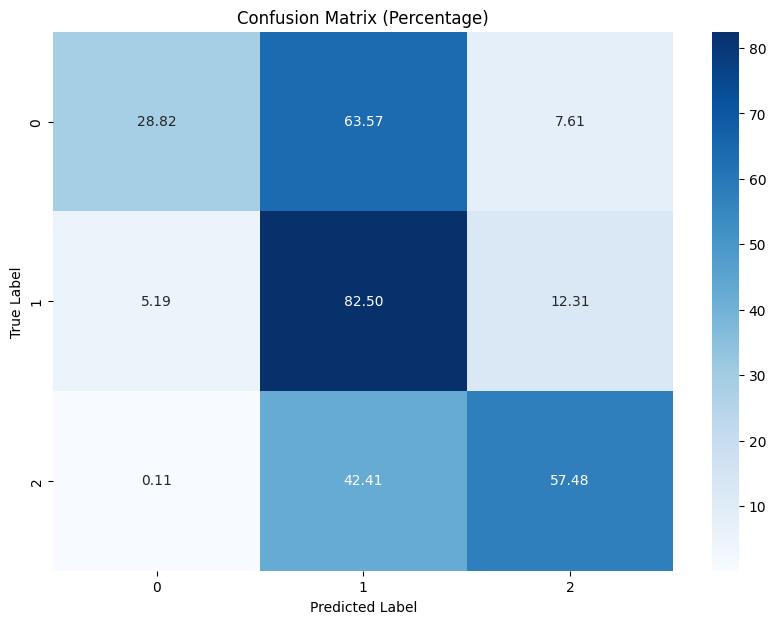

In [10]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the prediction column to integer
predictions = test_predictions.withColumn("prediction", F.col("prediction").cast("integer"))

# Create the confusion matrix
confusion_matrix = predictions.groupBy("tip_bin", "prediction").count()

# Compute total counts for each tip_bin
total_counts_per_tip_bin = confusion_matrix.groupBy("tip_bin").agg(F.sum("count").alias("total_count"))

# Join the total counts with the confusion matrix
confusion_matrix_with_totals = confusion_matrix.join(total_counts_per_tip_bin, on="tip_bin")

# Calculate percentages
confusion_matrix_percent = confusion_matrix_with_totals.withColumn(
    "percentage",
    (F.col("count") / F.col("total_count")) * 100
)

# Collect the results to a Pandas DataFrame for visualization
confusion_matrix_pd = confusion_matrix_percent.toPandas()

# Reshape the confusion matrix for heatmap
confusion_matrix_matrix = confusion_matrix_pd.pivot(
    index='tip_bin', columns='prediction', values='percentage'
).fillna(0)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix_matrix, annot=True, fmt=".2f", cmap="Blues", cbar=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Percentage)')

plt.savefig("../plots/confusion_matrix_MLP.png", format="png")



In [50]:
test_predictions

pulocationid,pu_day,pu_hour,is_weekend,is_peak_hour,trip_duration_minutes_scaled,trip_distance,fare_amount_scaled,wind_speed_scaled,dew_point_scaled,atmospheric_pressure_scaled,temperature_scaled,tip_bin,features,rawPrediction,probability,prediction
148,1,0,1,0,-0.2048,2.85,-0.3505,1.5346,-1.3043,0.4759,-0.8899,0,"[148.0,1.0,0.0,1....",[1.02820768654139...,[0.54112573230794...,0.0
137,1,0,1,0,-0.1511,4.63,0.0716,1.5346,-1.3043,0.4759,-0.8899,0,"[137.0,1.0,0.0,1....",[1.70440095307614...,[0.67116313304395...,0.0
45,1,0,1,0,-0.0476,5.33,0.2826,1.5346,-1.3043,0.4759,-0.8899,0,"[45.0,1.0,0.0,1.0...",[1.72853495526943...,[0.67544692403548...,0.0
163,1,0,1,0,-0.276,2.1,-0.4772,1.5346,-1.3043,0.4759,-0.8899,1,"[163.0,1.0,0.0,1....",[0.06799858503411...,[0.35491325639412...,1.0
144,1,0,1,0,-0.062,2.6,-0.3505,1.5346,-1.3043,0.4759,-0.8899,1,"[144.0,1.0,0.0,1....",[0.92642402762473...,[0.52073984722386...,0.0
234,1,0,1,0,-0.4048,0.8,-0.8571,1.5346,-1.3043,0.4759,-0.8899,2,"[234.0,1.0,0.0,1....",[-1.7412472287058...,[0.09312433472229...,2.0
233,1,0,1,0,-0.3166,1.6,-0.6882,1.5346,-1.3043,0.4759,-0.8899,1,"[233.0,1.0,0.0,1....",[-0.7689663952901...,[0.22140420687255...,1.0
24,1,0,1,0,-0.3402,0.77,-0.7726,1.5346,-1.3043,0.4759,-0.8899,2,"[24.0,1.0,0.0,1.0...",[-0.4112698353531...,[0.27556431632609...,1.0
138,1,0,1,0,0.0018,12.0,1.5489,1.5346,-1.3043,0.4759,-0.8899,0,"[138.0,1.0,0.0,1....",[1.74789734355398...,[0.67894759679939...,0.0
238,1,0,1,0,-0.279,1.7,-0.6038,1.5346,-1.3043,0.4759,-0.8899,0,"[238.0,1.0,0.0,1....",[-0.7101082733428...,[0.22969091929619...,1.0


In [12]:
model_path = "../MLP_trained"
model.save(model_path)